## Dataset

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2017 to September 2017.

## Content

There are 25 variables:

1.ID: ID of each client
2. LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
3.SEX: Gender (1=male, 2=female)
4. EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
5. MARRIAGE: Marital status (1=married, 2=single, 3=others)
6. AGE: Age in years
7. PAY_0: Repayment status in September, 2017 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
8. PAY_2: Repayment status in August, 2017 (scale same as above)
9. PAY_3: Repayment status in July, 2017 (scale same as above)
10. PAY_4: Repayment status in June, 2017 (scale same as above)
11. PAY_5: Repayment status in May, 2017 (scale same as above)
12. PAY_6: Repayment status in April, 2017 (scale same as above)
13. BILL_AMT1: Amount of bill statement in September, 2017 (NT dollar)
14. BILL_AMT2: Amount of bill statement in August, 2017 (NT dollar)
15. BILL_AMT3: Amount of bill statement in July, 2017 (NT dollar)
16. BILL_AMT4: Amount of bill statement in June, 2017 (NT dollar)
17. BILL_AMT5: Amount of bill statement in May, 2017 (NT dollar)
18. BILL_AMT6: Amount of bill statement in April, 2017 (NT dollar)
19. PAY_AMT1: Amount of previous payment in September, 2017 (NT dollar)
20. PAY_AMT2: Amount of previous payment in August, 2017 (NT dollar)
21. PAY_AMT3: Amount of previous payment in July, 2017 (NT dollar)
22. PAY_AMT4: Amount of previous payment in June, 2017 (NT dollar)
23. PAY_AMT5: Amount of previous payment in May, 2017 (NT dollar)
24. PAY_AMT6: Amount of previous payment in April, 2017 (NT dollar)
25. default.payment.next.month: Default payment (1=yes, 0=no)

In [0]:
## Loading required packages 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble.forest import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

## Set parameters

Here we set few parameters for the analysis and models.

In [0]:
RFC_MATRIX = 'gini' # matrix used for RandomForestClassifer
NUMBER_ESTIMATORS = 100 # no. of estimators used for RandomForestClassifer
NO_JOBS = 4 # no of parallel jobs used for RandomForestClassifer 

VALID_SIZE = 0.2 # validation 
NUMBER_KFLODS = 5 # no. of KFolds for cross-validation 

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000 #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

In [80]:
#importing dataset from AWS

!wget https://s3.ap-south-1.amazonaws.com/datasetsofdatascience/UCI_Credit_Card.csv

--2019-01-31 02:25:43--  https://s3.ap-south-1.amazonaws.com/datasetsofdatascience/UCI_Credit_Card.csv
Resolving s3.ap-south-1.amazonaws.com (s3.ap-south-1.amazonaws.com)... 52.219.64.37
Connecting to s3.ap-south-1.amazonaws.com (s3.ap-south-1.amazonaws.com)|52.219.64.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2862995 (2.7M) [text/csv]
Saving to: ‘UCI_Credit_Card.csv.2’

UCI_Credit_Card.csv 100%[===================>]   2.73M  1.67MB/s    in 1.6s    

2019-01-31 02:25:45 (1.67 MB/s) - ‘UCI_Credit_Card.csv.2’ saved [2862995/2862995]



In [0]:
data = pd.read_csv('UCI_Credit_Card.csv')

In [82]:
print('Credit Card Defaulters - rows:', data.shape[0], 'columns: ',data.shape[1]) # shape of the data

Credit Card Defaulters - rows: 30000 columns:  25


## Glimpse the data

In [83]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [84]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [85]:
data.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

In [0]:
data = data.drop(['ID'], axis = 1)

In [87]:
## checking for Missing values 

data.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


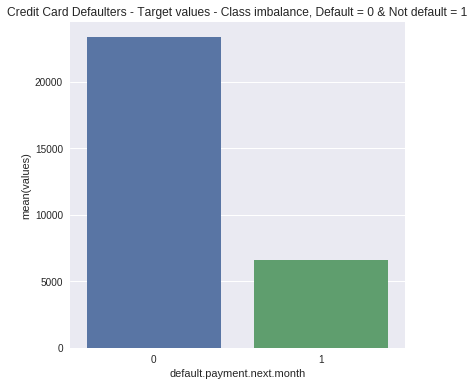

In [88]:
## Checking for Class imbalance with respect to target variable "default.payment.next.month"

temp = data['default.payment.next.month'].value_counts()
df = pd.DataFrame({'default.payment.next.month': temp.index, 'values': temp.values})
plt.figure(figsize=(6,6))
plt.title('Credit Card Defaulters - Target values - Class imbalance, Default = 0 & Not default = 1')
sns.set_color_codes('pastel')
sns.barplot(x = 'default.payment.next.month', y = 'values', data = df)
locs, labels = plt.xticks()
plt.show()

## Data Exploration 

Amount of Credit limit

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


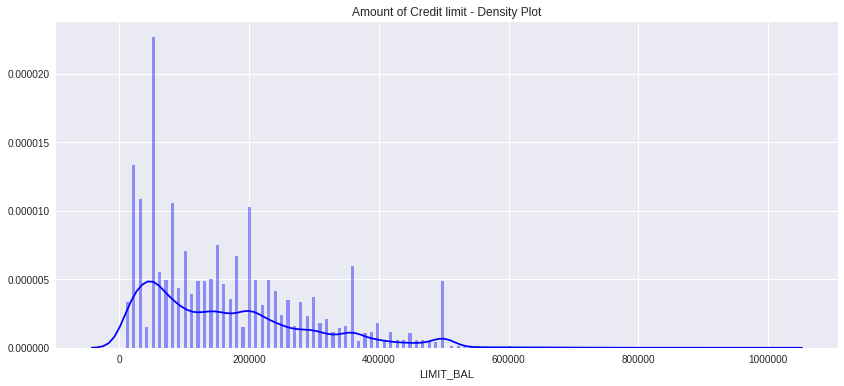

In [89]:
plt.figure(figsize=(14,6))
plt.title('Amount of Credit limit - Density Plot')
sns.set_color_codes('pastel')
sns.distplot(data['LIMIT_BAL'], kde = True, bins = 200, color = 'blue')
plt.show()

In [90]:
## Largest group of amount of credit limit is apparently for amount of 50K. Let's verify this.

data['LIMIT_BAL'].value_counts().shape

(81,)

There are 81 distinct values for amount of credit limit.

In [91]:
data['LIMIT_BAL'].value_counts().head()

50000.0     3365
20000.0     1976
30000.0     1610
80000.0     1567
200000.0    1528
Name: LIMIT_BAL, dtype: int64

the largest number of credit cards are with limit of 50,000 (3365), followed by 20,000 (1976) and 30,000 (1610)

## Amount of credit limit grouped by default payment next month

 visualize the density plot for amount of credit limit (LIMIT_BAL), grouped by default payment next month.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


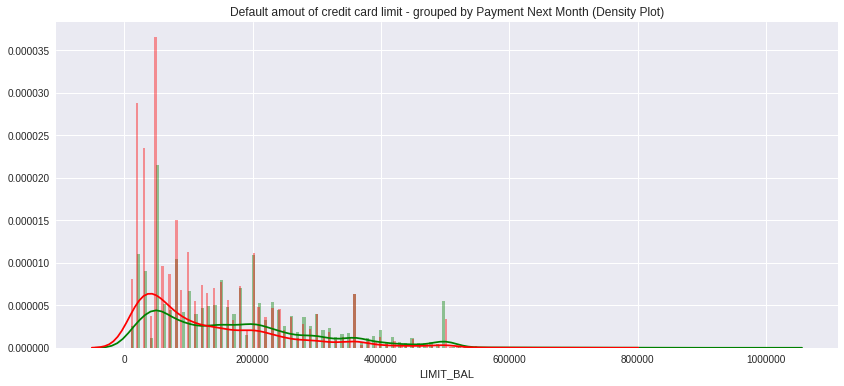

In [92]:
class_0 = data.loc[data['default.payment.next.month'] == 0]['LIMIT_BAL']
class_1 = data.loc[data['default.payment.next.month'] == 1]['LIMIT_BAL']
plt.figure(figsize=(14,6))
plt.title('Default amout of credit card limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes('pastel')
sns.distplot(class_0, kde = True, bins = 200, color = 'green')
sns.distplot(class_1, kde = True, bins = 200, color = 'red')
plt.show()

Most of defaults are for credit limits 0-100,000 (and density for this interval is larger for defaults than for non-defaults). Larger defaults number are for the amounts of 50,000, 20,000 and 30,000.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


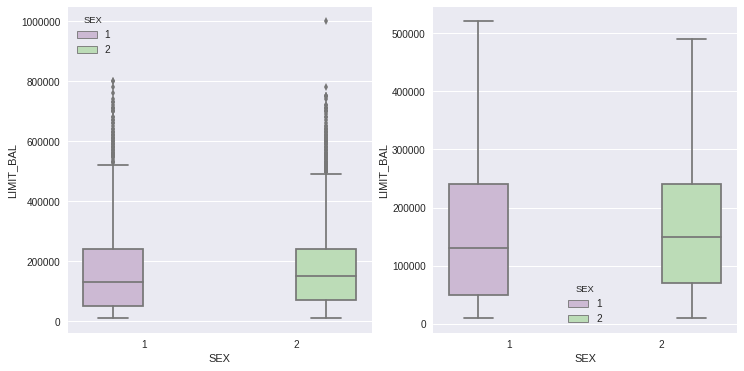

In [93]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,6))
s = sns.boxplot(ax = ax1, x = "SEX", y = 'LIMIT_BAL', hue = "SEX", data = data, palette="PRGn", showfliers = True)
s = sns.boxplot(ax = ax2, x = "SEX", y = "LIMIT_BAL", hue = 'SEX', data = data, palette = 'PRGn', showfliers= False)
plt.show();



The limit credit amount is quite balanced between sexes. The males have a slightly smaller Q2 and larger Q3 and Q4 and a lower mean. The female have a larger outlier max value (1M NT dollars).

## Features correlation


In [94]:
corr = data.corr()
corr.style.background_gradient()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
LIMIT_BAL,1,0.0247552,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.26746,-0.249411,-0.235195,0.28543,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.15352
SEX,0.0247552,1,0.0142319,-0.0313888,-0.0908736,-0.0576429,-0.070771,-0.0660961,-0.0601732,-0.0550639,-0.0440078,-0.0336419,-0.0311835,-0.0245633,-0.0218797,-0.0170052,-0.0167331,-0.000242455,-0.00139091,-0.00859662,-0.00222897,-0.00166716,-0.00276602,-0.0399606
EDUCATION,-0.219161,0.0142319,1,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.0975202,0.082316,0.0235812,0.0187488,0.0130024,-0.000451345,-0.0075665,-0.00909895,-0.0374562,-0.0300382,-0.0399431,-0.0382182,-0.0403585,-0.0371999,0.0280061
MARRIAGE,-0.108139,-0.0313888,-0.143464,1,-0.41417,0.0199172,0.0241991,0.0326877,0.0331215,0.0356292,0.0343448,-0.0234718,-0.0216018,-0.0249095,-0.0233438,-0.0253934,-0.0212068,-0.005979,-0.0080927,-0.00354135,-0.0126593,-0.00120476,-0.00664094,-0.0243392
AGE,0.144713,-0.0908736,0.175061,-0.41417,1,-0.0394474,-0.0501478,-0.0530484,-0.0497217,-0.053826,-0.0487734,0.0562385,0.0542831,0.0537097,0.0513531,0.049345,0.0476127,0.0261467,0.0217849,0.0292474,0.021379,0.02285,0.0194782,0.0138898
PAY_0,-0.271214,-0.0576429,0.105364,0.0199172,-0.0394474,1,0.672164,0.574245,0.538841,0.509426,0.474553,0.187068,0.189859,0.179785,0.179125,0.180635,0.17698,-0.0792687,-0.0701005,-0.0705608,-0.0640049,-0.0581899,-0.0586732,0.324794
PAY_2,-0.296382,-0.070771,0.121566,0.0241991,-0.0501478,0.672164,1,0.766552,0.662067,0.62278,0.575501,0.234887,0.235257,0.224146,0.222237,0.221348,0.219403,-0.0807007,-0.05899,-0.0559012,-0.0468584,-0.0370931,-0.0365004,0.263551
PAY_3,-0.286123,-0.0660961,0.114025,0.0326877,-0.0530484,0.574245,0.766552,1,0.777359,0.686775,0.632684,0.208473,0.237295,0.227494,0.227202,0.225145,0.222327,0.00129481,-0.0667934,-0.0533108,-0.0460665,-0.0358631,-0.0358611,0.235253
PAY_4,-0.26746,-0.0601732,0.108793,0.0331215,-0.0497217,0.538841,0.662067,0.777359,1,0.819835,0.716449,0.202812,0.225816,0.244983,0.245917,0.242902,0.239154,-0.00936214,-0.00194366,-0.0692352,-0.0434614,-0.0335895,-0.0265651,0.216614
PAY_5,-0.249411,-0.0550639,0.0975202,0.0356292,-0.053826,0.509426,0.62278,0.686775,0.819835,1,0.8169,0.206684,0.226913,0.243335,0.271915,0.269783,0.262509,-0.00608876,-0.00319133,0.00906236,-0.0582989,-0.0333365,-0.0230275,0.204149


In [95]:
# check the correlation of Amount of bill statement

amountStatement = data[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
corr1 = amountStatement.corr()
corr1.style.bar()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
BILL_AMT1,1,0.951484,0.892279,0.860272,0.829779,0.80265
BILL_AMT2,0.951484,1,0.928326,0.892482,0.859778,0.831594
BILL_AMT3,0.892279,0.928326,1,0.923969,0.88391,0.85332
BILL_AMT4,0.860272,0.892482,0.923969,1,0.940134,0.900941
BILL_AMT5,0.829779,0.859778,0.88391,0.940134,1,0.946197
BILL_AMT6,0.80265,0.831594,0.85332,0.900941,0.946197,1


Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.



In [96]:
# check the correlation of Amount of previous payment

amountOfPrevPay = data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']]
corr2 = amountOfPrevPay.corr()
corr2.style.bar()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5
PAY_AMT1,1,0.285576,0.252191,0.199558,0.148459
PAY_AMT2,0.285576,1,0.24477,0.180107,0.180908
PAY_AMT3,0.252191,0.24477,1,0.216325,0.159214
PAY_AMT4,0.199558,0.180107,0.216325,1,0.15183
PAY_AMT5,0.148459,0.180908,0.159214,0.15183,1


There are no correlations between amounts of previous payments for April-Sept



In [97]:
# check the correlation between Repayment status

repayment = data[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
corr3 = repayment.corr()
corr3.style.bar()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
PAY_0,1,0.672164,0.574245,0.538841,0.509426,0.474553
PAY_2,0.672164,1,0.766552,0.662067,0.62278,0.575501
PAY_3,0.574245,0.766552,1,0.777359,0.686775,0.632684
PAY_4,0.538841,0.662067,0.777359,1,0.819835,0.716449
PAY_5,0.509426,0.62278,0.686775,0.819835,1,0.8169
PAY_6,0.474553,0.575501,0.632684,0.716449,0.8169,1


Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.

# Building Predictive models

In [0]:
# defining target and predictors

target = 'default.payment.next.month'
predictors = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

In [0]:
train_df, valid_df = train_test_split(data, test_size = VALID_SIZE, random_state = RANDOM_STATE, shuffle = True)

## RandomForestClassifer 

In [0]:
clf = RandomForestClassifier(n_jobs=4, random_state=2018, criterion='gini', n_estimators=100, verbose = True)

In [101]:
# Let's train the RandonForestClassifier using the train_df data and fit function.

clf.fit(train_df[predictors],train_df[target].values)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=True,
            warm_start=False)

In [102]:
preds = clf.predict(valid_df[predictors])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


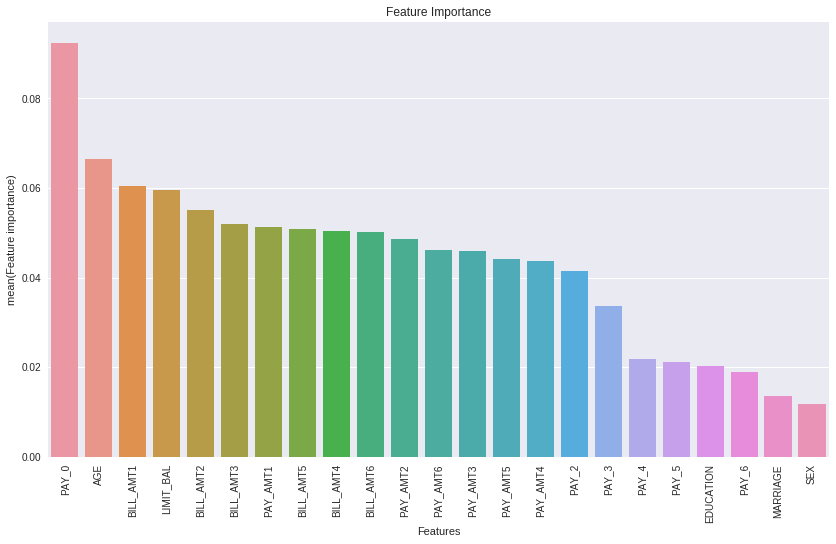

In [103]:
tmp = pd.DataFrame({'Features': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
plt.figure(figsize = (14,8))
plt.title('Feature Importance')
s = sns.barplot(x= 'Features', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
plt.show()

The most important features are **PAY_0, AGE, BILL_AMT1, LIMIT_BAL, BILL_AMT2, BILL_AMT3.**



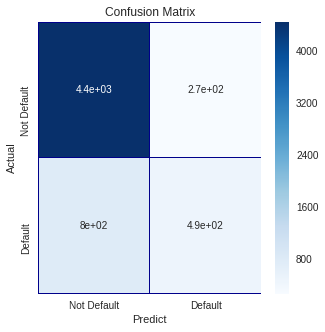

In [104]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predict'])
fig, (ax1) = plt.subplots(ncols=1, figsize = (5,5))
sns.heatmap(cm,
           xticklabels = ['Not Default', 'Default'],
           yticklabels = ['Not Default', 'Default'],
           annot = True, ax = ax1,
           linewidths = 0.2, linecolor = 'Darkblue', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.show()


In [105]:
roc_auc_score(valid_df[target].values, preds)

0.6625018741566295

# Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [0]:
glm = LogisticRegression()

In [108]:
glm.fit(train_df[predictors], train_df[target].values)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
glm_preds = glm.predict(valid_df[predictors])

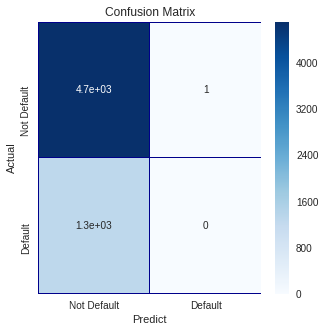

In [110]:
cm = pd.crosstab(valid_df[target].values, glm_preds, rownames=['Actual'], colnames=['Predict'])
fig, (ax1) = plt.subplots(ncols=1, figsize = (5,5))
sns.heatmap(cm,
           xticklabels = ['Not Default', 'Default'],
           yticklabels = ['Not Default', 'Default'],
           annot = True, ax = ax1,
           linewidths = 0.2, linecolor = 'Darkblue', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.show()


In [111]:
roc_auc_score(valid_df[target].values, glm_preds)

0.4998937977909941

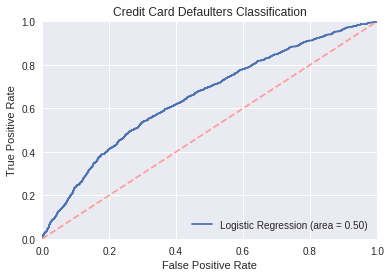

In [112]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(valid_df[target], glm.predict(valid_df[predictors]))
frp, trp, thersholds = roc_curve(valid_df[target], glm.predict_proba(valid_df[predictors])[:,1])
plt.figure()
plt.plot(frp, trp, label = 'Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Credit Card Defaulters Classification')
plt.legend(loc = 'lower right')
plt.savefig('Log_ROC')
plt.show()

# RandomForrest with OneHotEncoder

In [0]:
cat_features = ['SEX',	'EDUCATION',	'MARRIAGE', 'PAY_0',	'PAY_2',	'PAY_3',	'PAY_4',	'PAY_5',	'PAY_6']

In [0]:
train_f = train_df.copy()
valid_f = valid_df.copy()

In [0]:
train_copy = pd.get_dummies(train_df, columns=cat_features)
valid_copy = pd.get_dummies(valid_df, columns=cat_features)

In [116]:
print(train_copy.shape)
print(valid_copy.shape)

(24000, 92)
(6000, 85)


Because train and validation data does not have the same number of columns, we will align them.



In [117]:
train_copy.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
22659,150000.0,48,175095.0,175522.0,173918.0,174074.0,178671.0,178869.0,10011.0,6200.0,...,0,0,1,0,0,0,0,0,0,0
6618,180000.0,37,8788.0,40927.0,28306.0,31578.0,21195.0,11776.0,40970.0,1210.0,...,0,1,0,0,0,0,0,0,0,0
26605,20000.0,23,2400.0,2400.0,2400.0,2400.0,2400.0,1800.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2504,180000.0,30,440.0,30404.0,0.0,880.0,150.0,430.0,30404.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1111,50000.0,44,3424.0,155.0,1922.0,1473.0,1865.0,835.0,155.0,1922.0,...,0,1,0,0,0,0,0,0,0,0


In [118]:
valid_copy.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
8343,50000.0,30,37522.0,38614.0,39671.0,40213.0,41064.0,43382.0,2000.0,2000.0,...,0,0,0,1,0,0,0,0,0,0
2228,60000.0,29,53274.0,54093.0,53111.0,50568.0,47791.0,45421.0,2591.0,2109.0,...,0,0,0,1,0,0,0,0,0,0
6293,280000.0,55,2326.0,4917.0,4906.0,4707.0,2254.0,5375.0,4917.0,2453.0,...,0,0,1,0,0,0,0,0,0,0
16805,50000.0,43,4166.0,4166.0,4216.0,4166.0,4166.0,4166.0,4166.0,4216.0,...,0,0,1,0,0,0,0,0,0,0
3519,550000.0,34,383973.0,380082.0,389694.0,342198.0,344808.0,347188.0,15000.0,20000.0,...,0,0,0,1,0,0,0,0,0,0


In [0]:
train_copy, valid_copy = train_copy.align(valid_copy, join = 'outer', axis = 1, fill_value=0)

In [120]:
print(train_copy.shape)
print(valid_copy.shape)

(24000, 92)
(6000, 92)


In [121]:
train_copy.columns

Index(['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6', 'LIMIT_BAL', 'MARRIAGE_0',
       'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-1', 'PAY_0_-2',
       'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5',
       'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_-2', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_-2', 'PAY_3_0', 'PAY_3_1',
       'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7',
       'PAY_3_8', 'PAY_4_-1', 'PAY_4_-2', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2',
       'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8',
       'PAY_5_-1', 'PAY_5_-2', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3', 'PAY_5_4',
       'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-1', 'PAY_6_-2',
       'PAY_6_0', 'PAY

In [0]:
## define predictors and target

target = 'default.payment.next.month'

predictors1 = ['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6', 'LIMIT_BAL', 'MARRIAGE_0',
       'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-1', 'PAY_0_-2',
       'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5',
       'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_-2', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_-2', 'PAY_3_0', 'PAY_3_1',
       'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7',
       'PAY_3_8', 'PAY_4_-1', 'PAY_4_-2', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2',
       'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8',
       'PAY_5_-1', 'PAY_5_-2', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3', 'PAY_5_4',
       'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-1', 'PAY_6_-2',
       'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6',
       'PAY_6_7', 'PAY_6_8', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
       'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2']

In [123]:
clf.fit(train_copy[predictors1],train_df[target].values)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=True,
            warm_start=False)

In [124]:
preds = clf.predict(valid_copy[predictors1])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


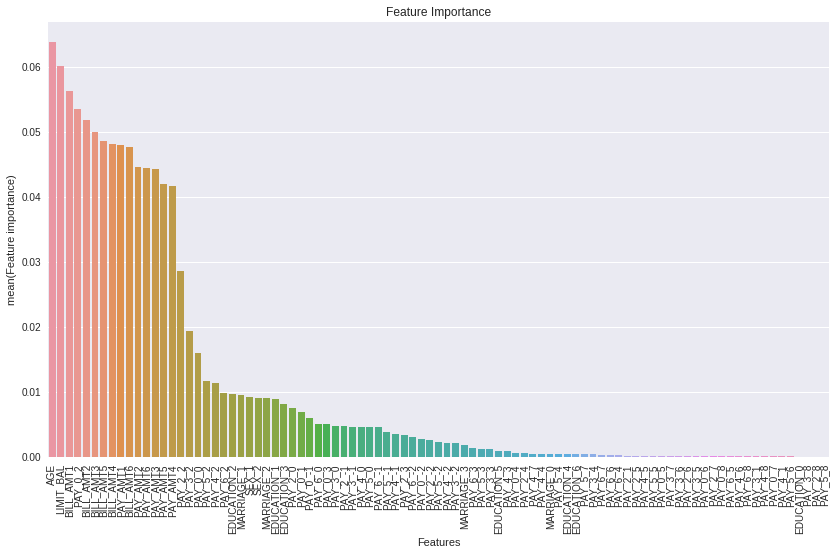

In [125]:
tmp = pd.DataFrame({'Features': predictors1, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
plt.figure(figsize = (14,8))
plt.title('Feature Importance')
s = sns.barplot(x= 'Features', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
plt.show()

The most important features are **AGE, LIMIT_BAL, BILL_AMT1, PAY_0_2, BILL_AMT2, BILL_AMT3.**


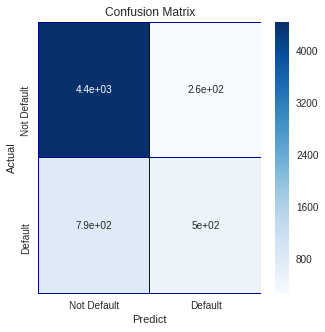

In [126]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predict'])
fig, (ax1) = plt.subplots(ncols=1, figsize = (5,5))
sns.heatmap(cm,
           xticklabels = ['Not Default', 'Default'],
           yticklabels = ['Not Default', 'Default'],
           annot = True, ax = ax1,
           linewidths = 0.2, linecolor = 'Darkblue', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.show()


In [127]:
roc_auc_score(valid_df[target].values, preds)

0.6667660736878931

# XGBoost

**Prepare the model**

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [0]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [139]:
# train the model

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.692712	valid-auc:0.698104
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.769043	valid-auc:0.764839
[100]	train-auc:0.777095	valid-auc:0.772625
[150]	train-auc:0.782957	valid-auc:0.776749
[200]	train-auc:0.786582	valid-auc:0.778071
[250]	train-auc:0.789083	valid-auc:0.779616
[300]	train-auc:0.791822	valid-auc:0.780685
[350]	train-auc:0.793941	valid-auc:0.781236
[400]	train-auc:0.795611	valid-auc:0.781681
[450]	train-auc:0.797517	valid-auc:0.78211
[500]	train-auc:0.799009	valid-auc:0.781907
Stopping. Best iteration:
[468]	train-auc:0.797934	valid-auc:0.782154



The best validation score (ROC-AUC) was **0.78**, for round **468**.



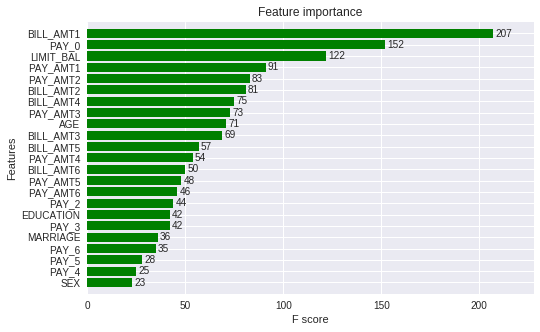

In [143]:
fig, (ax) = plt.subplots(ncols=1, figsize = (8,5))
xgb.plot_importance(model, height=0.8, title='Feature importance', ax = ax, color = 'green')
plt.show()